In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, LeaveOneOut
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json
import cupy
from tqdm import tqdm
from gtfparse import read_gtf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn import svm
from xgboost import XGBRegressor
from scipy.stats import spearmanr

from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE


In [2]:
transcripts = {
    "HEART": {
        "male": [],
        "female": []
    }, 
    "BRAIN0": {
        "male": [],
        "female": []
    }, 
    "BRAIN1": {
        "male": [],
        "female": []
    }, 
}

In [3]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

# value_to_predict = 'population'
value_to_predict = 'Age'

organ = "HEART"
# organ = "BRAIN0"
organ = "BRAIN1"
# 
sex = 'male'
sex = 'female'

n_opt_features = {
    "HEART": {
        "male": 9,
        "female": 11
    }, 
    "BRAIN0": {
        "male": 7,
        "female": 7
    }, 
    "BRAIN1": {
        "male": 17,
        "female": 8
    }, 
}

# transcripts[organ] = {}
# transcripts[organ][sex] = []


In [ ]:
fdir_processed / f'{organ}.preprocessed.h5'

PosixPath('../data/interim/BRAIN1.preprocessed.h5')

In [5]:
data = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="data")
data_header = pd.read_hdf(fdir_processed / f'{organ}.preprocessed.h5', key="header")

# data = data.iloc[:, np.argwhere(np.sum(data > 0, axis=0) > 18).ravel()]


if organ == "BRAIN1":
    data_header['sex'] = data_header['gender'] 


data_male = data.loc[data_header['sex'] == "male"]
data_female = data.loc[data_header['sex'] == "female"]

data_header_male = data_header.loc[data_header['sex'] == "male"]
data_header_female = data_header.loc[data_header['sex'] == "female"]

# data_male = data.loc[data_header['tissue'] == "Putamen"]
# data_female = data.loc[data_header['tissue'] != "Putamen"]

# data_header_male = data_header.loc[data_header['tissue'] == "Putamen"]
# data_header_female = data_header.loc[data_header['tissue'] != "Putamen"]



# fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
# sns.regplot(y=data[data.columns[0]], x=data_header['Age'], ax=axs[0], label='male+female')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
#             label='male')
# sns.regplot(y=data[data.columns[0]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
#             label='female')
# axs[0].legend()
# axs[1].legend()

data_both = data.copy(deep=True)
data_header_both = data_header.copy(deep=True)

# data = data.loc[data_header['sex'] == sex]
# data_header = data_header.loc[data_header['sex'] == sex]

data = data.loc[data_header['tissue'] != "Nac"]
data_header = data_header.loc[data_header['tissue'] != "Nac"]



In [6]:
# import anndata as ad
# import scanpy as sc

# adata = ad.AnnData(data)
# adata.var = gtf_data
# adata.obs = data_header


In [7]:
rhos_male = []
pvalues_male = []
rhos_female = []
pvalues_female = []

for i in tqdm(range(data_male.values.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(data_male.values[:, i], data_header_male['Age'].values)
    rhos_male.append(rho)
    pvalues_male.append(pvalue)
    
for i in tqdm(range(data_female.values.shape[1])):
    rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
    rhos_female.append(rho)
    pvalues_female.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
rhos_male = np.array(rhos_male)
rhos_female = np.array(rhos_female)

  0%|          | 0/17915 [00:00<?, ?it/s]

  0%|          | 0/17915 [00:00<?, ?it/s]/tmp/ipykernel_57937/2184972271.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, pvalue = spearmanr(data_female.values[:, i], data_header_female['Age'].values)
100%|██████████| 17915/17915 [00:14<00:00, 1204.76it/s]


In [8]:
from statsmodels.stats.multitest import multipletests

reject, pvals_corrected, sidac, bonf = multipletests(pvalues_male, alpha=0.05)
# pvalues_male, pvals_corrected
np.argwhere(reject)

array([[1728]])

nan
0.20023947206063547
nan


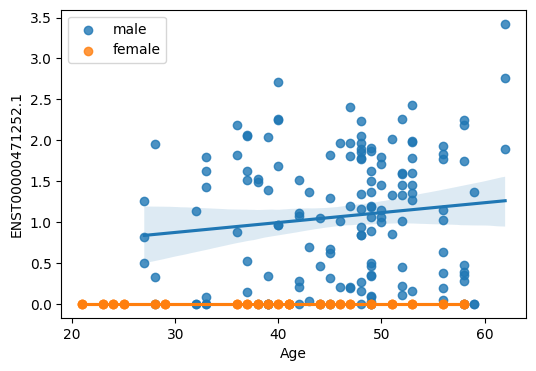

In [9]:
# rhos_male_sign = rhos_male > 0
# rhos_female_sign = rhos_female > 0

# diff_corr_ids = np.where(np.logical_xor(rhos_male_sign, rhos_female_sign))
# diff_corr_ids_sorted = np.argsort(np.abs(rhos_female[diff_corr_ids]))[::-1]

diff_corr_ids_sorted = np.argsort((rhos_male - rhos_female)**2)[::-1]

# print(diff_corr_ids_sorted)
index = 2
# diff_corr_ids_sorted[index] = 1728

print((rhos_male - rhos_female)[diff_corr_ids_sorted[index]])

print(pvalues_male[diff_corr_ids_sorted[index]])
print(pvalues_female[diff_corr_ids_sorted[index]])

fig, axs = plt.subplots(figsize=(6, 4))
# sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data_male[data_male.columns[diff_corr_ids_sorted[index]]], x=data_header_male['Age'], ax=axs, label='male')
sns.regplot(y=data_female[data_female.columns[diff_corr_ids_sorted[index]]], x=data_header_female['Age'], ax=axs, label='female')
axs.legend()


In [10]:
# eval_organ = "BRAIN0"
# eval_organ = "BRAIN1"
# eval_organ = 'HEART'
eval_organ = organ

fname = next((fdir_external / eval_organ / 'reg').glob("*processed.h5"))
fname = fname.name
data_eval = pd.read_hdf(fdir_external / eval_organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / eval_organ / 'reg' / 'SraRunTable.txt', sep=',')
data_eval_header.set_index("Run", inplace=True)

if eval_organ == "BRAIN1":
    data_eval_header['sex'] = data_eval_header['gender'] 

data_eval_header = data_eval_header.loc[data_eval_header['sex'] == sex]
data_eval = data_eval.loc[(data_eval_header['sex'] == sex).index]


In [11]:
common_transcripts = data.columns.intersection(data_eval.columns)

data_eval = data_eval[common_transcripts]
data = data[common_transcripts]
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147434,0.035113,0.000000,0.000000,0.000000,2.541312,1.165357,0.000000,0.000000,0.000000,1.324862,...,0.439607,0.412652,0.962864,0.161302,0.481970,0.112381,0.045710,2.256034,1.917703,0.000000
SRR19147435,0.028958,0.000000,0.834745,1.847615,2.891965,1.902646,0.172238,0.695127,0.000000,0.000000,...,0.000000,0.358886,0.158193,1.170810,0.000000,0.395059,0.000000,0.413721,1.591116,0.348319
SRR19147436,0.026559,0.000000,0.543138,0.000000,0.000000,2.253369,0.000000,0.012604,0.080319,1.091911,...,0.000000,0.000000,0.000000,2.064195,0.000000,0.398859,0.403035,0.000000,2.387390,1.570008
SRR19147437,0.048312,0.000000,0.000000,0.000000,0.000000,4.136106,3.016967,0.300410,0.000000,0.562984,...,0.000000,1.130694,0.834678,2.205190,0.534288,0.150727,0.169303,0.000000,2.027091,1.063526
SRR19147438,0.000000,0.000000,0.000000,0.000000,3.418941,0.000000,1.557123,0.000000,0.000000,1.654769,...,1.368054,0.930568,0.554803,0.000000,0.000000,0.155173,0.019762,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147622,2.310117,0.000000,0.000000,3.570329,0.000000,2.650285,0.242110,0.000000,0.437902,0.094893,...,0.000000,1.047083,0.000007,2.562498,0.282108,0.076612,0.151568,2.210053,0.000000,1.352333
SRR19147623,0.078848,1.294475,0.887752,0.935157,2.012549,1.377303,0.209941,0.000000,0.000000,1.243662,...,1.134204,0.003277,1.373302,0.816292,0.301315,0.378907,1.170298,0.247231,1.743819,0.536275
SRR19147624,1.787137,0.851233,1.250842,2.013755,0.000000,2.758592,0.118433,2.844183,1.733174,0.993974,...,0.000000,0.141227,0.380603,0.000000,0.285498,0.171355,0.884438,0.109038,1.315737,0.425569
SRR19147625,0.036838,1.444332,0.000000,3.847288,3.340400,2.200512,0.058135,0.506627,1.792845,0.024805,...,0.278599,0.751615,0.000000,0.808129,0.285959,0.216765,0.867302,0.000000,1.403870,0.786544


In [12]:
rhos = []
pvalues = []

# y = data_header.loc[data_header['sex'] == sex][value_to_predict]
# X = data.loc[data_header['sex'] == sex].values

y = data_header.loc[data_header['tissue'] != "Nac"][value_to_predict]
X = data.loc[data_header['tissue'] != "Nac"].values


for i in tqdm(range(X.shape[1])):
    # rho, pvalue = spearmanr(X[:, i], y)
    rho, pvalue = spearmanr(X[:, i], y)
    rhos.append(rho)
    pvalues.append(pvalue)
# rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)

reject, pvalues_corrected, sidac, bonf = multipletests(pvalues, alpha=0.05, method='fdr_bh')
np.argwhere(reject), np.argwhere(np.array(pvalues) < 0.05)

100%|██████████| 17915/17915 [00:15<00:00, 1143.15it/s]


(array([[2820],
        [3027],
        [8241],
        [8433]]),
 array([[    9],
        [   13],
        [   30],
        ...,
        [17723],
        [17860],
        [17901]]))

In [13]:
# np.argwhere(np.array(pvalues) < 0.05).shape

# unsignificant_corr_ids = np.argwhere(np.array(pvalues_corrected) > 0.05)
unsignificant_corr_ids = np.argwhere(np.array(pvalues) > 0.05)

# unsignificant_corr_ids

rhos = np.array(rhos)
rhos[unsignificant_corr_ids] = 0
rhos[np.argwhere(X.mean(axis=0) == 0)] = 0


### Select by correlation value

In [14]:
# Select by correlation value

corr_threshold = 0.96
corr_threshold = 0.5
corr_threshold = 0.1

if np.abs(rhos).max() > corr_threshold:
    sorted_corr_border = np.argwhere(np.sort(np.abs(rhos))[::-1] > corr_threshold).max()
    sorted_corr_ids = np.argsort(np.abs(rhos))[::-1][:sorted_corr_border]
    # np.sort(np.abs(rhos))[::-1][:sorted_corr_border], sorted_corr_ids
else:
    sorted_corr_ids = []
sorted_corr_ids, sorted_corr_ids.shape

(array([ 8241,  2820,  3027, ..., 15111,  9041,  9881]), (1033,))

### Select by feature importance 

In [15]:
# # select by feature importance
# model = XGBRegressor(n_estimators=300, max_depth=4, )

# X = data.values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

# # model.fit(RobustScaler().fit_transform(X),  y)
# model.fit(X,  y)
# importances = model.feature_importances_

# sorted_corr_ids = np.argsort(importances).ravel()[::-1][:50]

### Select by Scanpy variance

In [16]:
# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")

gtf_data

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
ENST00000003912.7,chr1,StringTie,transcript,24415803,24473468,1000.0,+,0,MSTRG.676,,NIPAL3,ENSG00000001461.17,ENST00000003912.7
ENST00000004103.8,chr7,StringTie,transcript,150800769,150806496,1000.0,+,0,MSTRG.32371,,TMEM176A,ENSG00000002933.9,ENST00000004103.8
ENST00000005340.10,chr17,StringTie,transcript,7225342,7234732,1000.0,-,0,MSTRG.14242,,DVL2,ENSG00000004975.12,ENST00000005340.10
ENST00000006658.11,chr17,StringTie,transcript,50547174,50555852,1000.0,+,0,MSTRG.15427,,SPATA20,ENSG00000006282.22,ENST00000006658.11
ENST00000011473.6,chr7,StringTie,transcript,106090505,106112589,1000.0,-,0,MSTRG.31874,,SYPL1,ENSG00000008282.10,ENST00000011473.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSTRG.9948.7,chr14,StringTie,transcript,24439782,24442905,1000.0,-,0,MSTRG.9948,,,,MSTRG.9948.7
MSTRG.9968.1,chr14,StringTie,transcript,30622137,30737694,1000.0,+,0,MSTRG.9968,,,,MSTRG.9968.1
MSTRG.9975.19,chr14,StringTie,transcript,31561457,31861290,1000.0,+,0,MSTRG.9975,,,,MSTRG.9975.19
MSTRG.9996.5,chr14,StringTie,transcript,30880617,30886923,1000.0,-,0,MSTRG.9996,,,,MSTRG.9996.5


In [17]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(data)
adata.var = gtf_data
adata.obs = data_header



In [18]:
# disease_state
adata.obs[['DATASTORE filetype',
       'DATASTORE provider', 'DATASTORE region', 'disease_state', 'Experiment',
       'gender', 'Instrument', 'Library Name', 'library_size', 'LibraryLayout',
       'LibrarySelection', 'LibrarySource', 'manner_of_death', 'Organism',
       'patients_ID', 'PH', 'Platform', 'pmi', 'RACE', 'ReleaseDate',]]

,DATASTORE filetype,DATASTORE provider,DATASTORE region,disease_state,Experiment,gender,Instrument,Library Name,library_size,LibraryLayout,LibrarySelection,LibrarySource,manner_of_death,Organism,patients_ID,PH,Platform,pmi,RACE,ReleaseDate
SRR19147434,"run.zq,sra,fastq","ncbi,gs,s3","ncbi.public,gs.US,s3.us-east-1",psychosis_schizophrenia,SRX15214383,female,NextSeq 500,GSM6123999,37391426,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,843,7.1,ILLUMINA,17.1,White,2022-08-31T00:00:00Z
SRR19147435,"fastq,sra,run.zq","ncbi,s3,gs","s3.us-east-1,gs.US,ncbi.public",match control,SRX15214382,male,NextSeq 500,GSM6123998,32401058,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,822,7.2,ILLUMINA,25.1,Black,2022-08-31T00:00:00Z
SRR19147436,"fastq,run.zq,sra","ncbi,gs,s3","gs.US,s3.us-east-1,ncbi.public",psychosis_schizophrenia,SRX15214381,male,NextSeq 500,GSM6123997,30529401,PAIRED,cDNA,TRANSCRIPTOMIC,Suicide,Homo sapiens,787,6.9,ILLUMINA,19.1,Black,2022-08-31T00:00:00Z
SRR19147437,"run.zq,fastq,sra","gs,ncbi,s3","ncbi.public,gs.US,s3.us-east-1",psychosis_schizophrenia,SRX15214384,male,NextSeq 500,GSM6124000,34023545,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,878,6.9,ILLUMINA,11.2,White,2022-08-31T00:00:00Z
SRR19147438,"sra,run.zq,fastq","s3,gs,ncbi","gs.US,ncbi.public,s3.us-east-1",match control,SRX15214380,male,NextSeq 500,GSM6123996,30515047,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,739,6.7,ILLUMINA,15.8,White,2022-08-31T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147622,"fastq,run.zq,sra","s3,gs,ncbi","gs.US,s3.us-east-1,ncbi.public",match control,SRX15214196,male,NextSeq 500,GSM6123963,33613429,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13069,6.8,ILLUMINA,25.8,White,2022-08-31T00:00:00Z
SRR19147623,"fastq,run.zq,sra","gs,s3,ncbi","ncbi.public,s3.us-east-1,gs.US",match control,SRX15214195,male,NextSeq 500,GSM6123962,34675663,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13068,6.8,ILLUMINA,12.8,White,2022-08-31T00:00:00Z
SRR19147624,"fastq,sra,run.zq","gs,s3,ncbi","gs.US,ncbi.public,s3.us-east-1",psychosis_schizophrenia,SRX15214194,female,NextSeq 500,GSM6123961,39553995,PAIRED,cDNA,TRANSCRIPTOMIC,Undetermined,Homo sapiens,13045,6.3,ILLUMINA,8.3,White,2022-08-31T00:00:00Z
SRR19147625,"sra,fastq,run.zq","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.US",psychosis_schizophrenia,SRX15214192,male,NextSeq 500,GSM6123959,37580048,PAIRED,cDNA,TRANSCRIPTOMIC,Natural,Homo sapiens,13017,6.6,ILLUMINA,25.3,White,2022-08-31T00:00:00Z


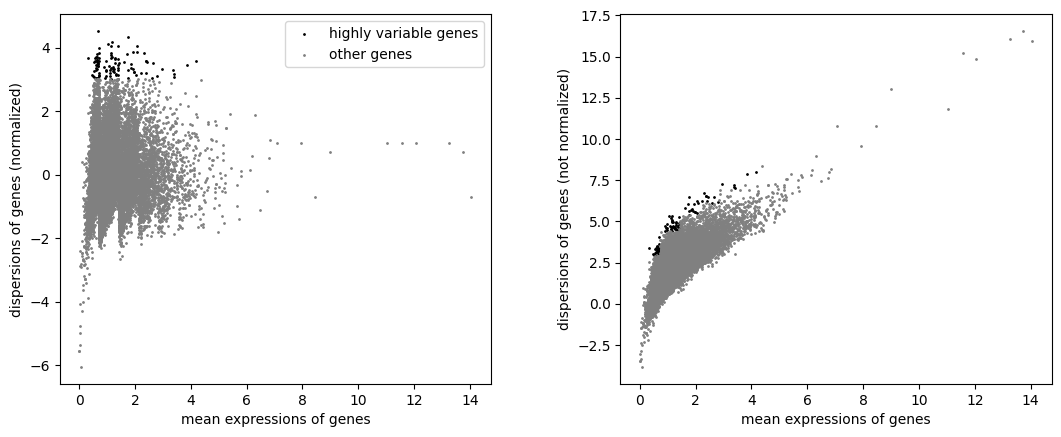

In [19]:
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='seurat')
sc.pl.highly_variable_genes(adata)


In [20]:
corr_ids = np.argwhere(adata.var['highly_variable']).ravel()
# corr_ids
sorted_corr_ids = corr_ids[np.argsort(adata[:, corr_ids].var['highly_variable_rank'].values)[::-1]]
adata[:, sorted_corr_ids].var

KeyError: 'highly_variable_rank'

# EVALUATE

In [16]:
data.columns[sorted_corr_ids]

Index(['ENST00000651708.1', 'ENST00000437783.1', 'ENST00000447280.6',
       'ENST00000660183.1', 'MSTRG.36752.1', 'MSTRG.16550.13',
       'ENST00000701016.1', 'ENST00000426347.5', 'ENST00000652128.1',
       'MSTRG.17745.9',
       ...
       'MSTRG.20726.1', 'ENST00000536785.1', 'ENST00000557833.1',
       'ENST00000578511.5', 'ENST00000595125.5', 'ENST00000319778.11',
       'MSTRG.36361.4', 'MSTRG.31080.3', 'ENST00000679936.1',
       'ENST00000704009.1'],
      dtype='object', length=1033)

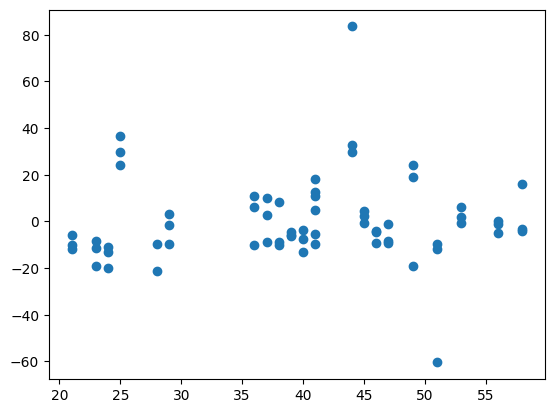

In [17]:
# # plt.figure(figsize=(16,6))
# sns.scatterplot(
#     y=np.abs(rhos[sorted_corr_ids]), 
#     x=data.columns[sorted_corr_ids],
#     )
# plt.xticks(rotation=90)


# X = data[data.columns[sorted_corr_ids[:n_features]]].values
# y = data_header['Age'].loc[data_header['sex'] == sex].values

from sklearn.decomposition import PCA

pca = PCA(None)
X_trainsformed = pca.fit_transform(data_female)
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
# plt.plot(X_trainsformed[:,0], X_trainsformed[:,1], 'o')
plt.plot(data_header_female['Age'], X_trainsformed[:,3], 'o')
# plt.plot(data_header_both['Age'], X_trainsformed[:,0], 'o')

In [18]:
data.columns[sorted_corr_ids], len(sorted_corr_ids) 

(Index(['ENST00000651708.1', 'ENST00000437783.1', 'ENST00000447280.6',
        'ENST00000660183.1', 'MSTRG.36752.1', 'MSTRG.16550.13',
        'ENST00000701016.1', 'ENST00000426347.5', 'ENST00000652128.1',
        'MSTRG.17745.9',
        ...
        'MSTRG.20726.1', 'ENST00000536785.1', 'ENST00000557833.1',
        'ENST00000578511.5', 'ENST00000595125.5', 'ENST00000319778.11',
        'MSTRG.36361.4', 'MSTRG.31080.3', 'ENST00000679936.1',
        'ENST00000704009.1'],
       dtype='object', length=1033),
 1033)

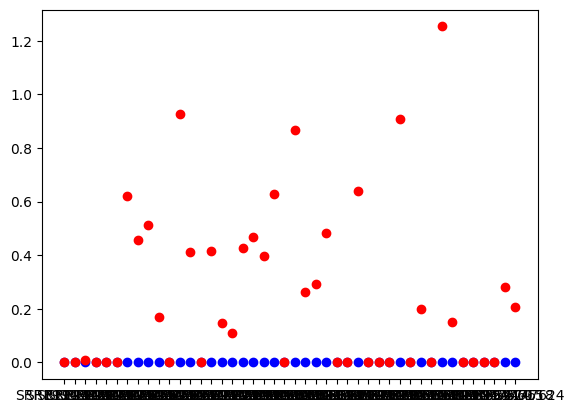

In [19]:
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]], 'bo')
plt.plot(data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][1]], 'ro')

In [20]:
data.loc[data_header['sex'] == sex][data.columns[sorted_corr_ids][0]]

SRR19147434    0.0
SRR19147442    0.0
SRR19147446    0.0
SRR19147447    0.0
SRR19147449    0.0
SRR19147451    0.0
SRR19147455    0.0
SRR19147457    0.0
SRR19147459    0.0
SRR19147461    0.0
SRR19147467    0.0
SRR19147469    0.0
SRR19147472    0.0
SRR19147477    0.0
SRR19147481    0.0
SRR19147489    0.0
SRR19147491    0.0
SRR19147495    0.0
SRR19147496    0.0
SRR19147503    0.0
SRR19147506    0.0
SRR19147508    0.0
SRR19147510    0.0
SRR19147514    0.0
SRR19147515    0.0
SRR19147520    0.0
SRR19147523    0.0
SRR19147526    0.0
SRR19147528    0.0
SRR19147529    0.0
SRR19147531    0.0
SRR19147562    0.0
SRR19147565    0.0
SRR19147568    0.0
SRR19147570    0.0
SRR19147571    0.0
SRR19147573    0.0
SRR19147575    0.0
SRR19147584    0.0
SRR19147587    0.0
SRR19147610    0.0
SRR19147615    0.0
SRR19147618    0.0
SRR19147624    0.0
Name: ENST00000651708.1, dtype: float32

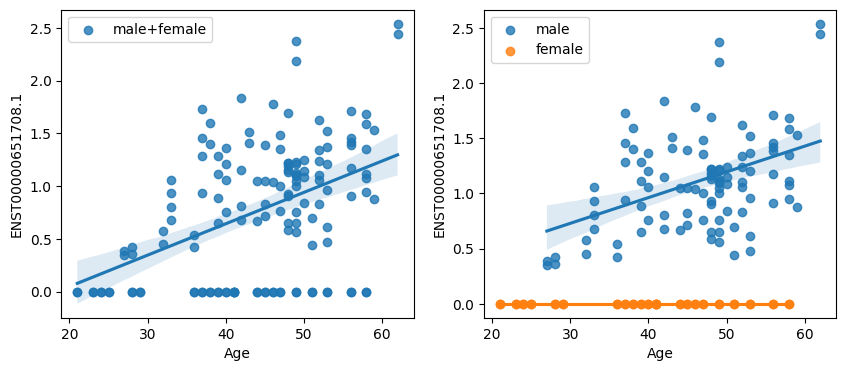

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]], x=data_header['Age'], ax=axs[0], label='male+female')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'male'], x=data_header['Age'].loc[data_header['sex'] == 'male'], ax=axs[1], 
            label='male')
sns.regplot(y=data[data.columns[sorted_corr_ids[0]]].loc[data_header['sex'] == 'female'], x=data_header['Age'].loc[data_header['sex'] == 'female'], ax=axs[1], 
            label='female')
axs[0].legend()
axs[1].legend()

In [22]:
data

,ENST00000003912.7,ENST00000004103.8,ENST00000005340.10,ENST00000006658.11,ENST00000011473.6,ENST00000012134.7,ENST00000019019.6,ENST00000040877.2,ENST00000043402.8,ENST00000070846.11,...,MSTRG.9920.54,MSTRG.9929.23,MSTRG.9929.7,MSTRG.993.1,MSTRG.9947.1,MSTRG.9948.7,MSTRG.9968.1,MSTRG.9975.19,MSTRG.9996.5,MSTRG.9996.8
SRR19147434,0.035113,0.000000,0.000000,0.000000,2.541312,1.165357,0.000000,0.000000,0.000000,1.324862,...,0.439607,0.412652,0.962864,0.161302,0.481970,0.112381,0.045710,2.256034,1.917703,0.000000
SRR19147435,0.028958,0.000000,0.834745,1.847615,2.891965,1.902646,0.172238,0.695127,0.000000,0.000000,...,0.000000,0.358886,0.158193,1.170810,0.000000,0.395059,0.000000,0.413721,1.591116,0.348319
SRR19147436,0.026559,0.000000,0.543138,0.000000,0.000000,2.253369,0.000000,0.012604,0.080319,1.091911,...,0.000000,0.000000,0.000000,2.064195,0.000000,0.398859,0.403035,0.000000,2.387390,1.570008
SRR19147437,0.048312,0.000000,0.000000,0.000000,0.000000,4.136106,3.016967,0.300410,0.000000,0.562984,...,0.000000,1.130694,0.834678,2.205190,0.534288,0.150727,0.169303,0.000000,2.027091,1.063526
SRR19147438,0.000000,0.000000,0.000000,0.000000,3.418941,0.000000,1.557123,0.000000,0.000000,1.654769,...,1.368054,0.930568,0.554803,0.000000,0.000000,0.155173,0.019762,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR19147622,2.310117,0.000000,0.000000,3.570329,0.000000,2.650285,0.242110,0.000000,0.437902,0.094893,...,0.000000,1.047083,0.000007,2.562498,0.282108,0.076612,0.151568,2.210053,0.000000,1.352333
SRR19147623,0.078848,1.294475,0.887752,0.935157,2.012549,1.377303,0.209941,0.000000,0.000000,1.243662,...,1.134204,0.003277,1.373302,0.816292,0.301315,0.378907,1.170298,0.247231,1.743819,0.536275
SRR19147624,1.787137,0.851233,1.250842,2.013755,0.000000,2.758592,0.118433,2.844183,1.733174,0.993974,...,0.000000,0.141227,0.380603,0.000000,0.285498,0.171355,0.884438,0.109038,1.315737,0.425569
SRR19147625,0.036838,1.444332,0.000000,3.847288,3.340400,2.200512,0.058135,0.506627,1.792845,0.024805,...,0.278599,0.751615,0.000000,0.808129,0.285959,0.216765,0.867302,0.000000,1.403870,0.786544


In [23]:
from statsmodels.genmod.generalized_linear_model import GLM

data_statsmod = sm.datasets.scotland.load()
data_statsmod.endog


0     60.3
1     52.3
2     53.4
3     57.0
4     68.7
5     48.8
6     65.5
7     70.5
8     59.1
9     62.7
10    51.6
11    62.0
12    68.4
13    69.2
14    64.7
15    75.0
16    62.1
17    67.2
18    67.7
19    52.7
20    65.7
21    72.2
22    47.4
23    51.3
24    63.6
25    50.7
26    51.6
27    56.2
28    67.6
29    58.9
30    74.7
31    67.3
Name: YES, dtype: float64

In [24]:
from linear_regressions_mixture import LinearRegressionsMixture



In [25]:
from sklearn.preprocessing import PolynomialFeatures


# n_features = 5
# n_features = -1

# sex = 'male'

print(data.shape[0])

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [2]:

    X = data[data.columns[sorted_corr_ids[:n_features]]].values
    # y = data_header['Age'].loc[data_header['sex'] == sex].values
    y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

    
    # print(X.shape)
    print(f"{n_features=}")
    
    cv = StratifiedKFold(n_splits=5)
    # cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values

        # poly = PolynomialFeatures(degree=2)
        # X_train_ = poly.fit_transform(X_train_)
        # X_val = poly.transform(X_val)
        
        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        # # print(f"{X_train_.shape=}")
        # # print(f"{X_val.shape=}")
        # epsilon = 1e-4
        # lam = 0.1
        # iterations = 50
        # random_restarts = 20
        # model = LinearRegressionsMixture(X_train_, np.expand_dims(y_train_, axis=1), K=2)
        # model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)
        # pred = [model.predict(X_val[i]) for i in range(X_val.shape[0])]

        preds.extend(pred)
        vals.extend(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLM(y_train_, X_train_,
        #              family=sm.families.NegativeBinomial()).fit()
        
        # gls_pred = mod.predict(X_test)
        # gls_preds.extend(gls_pred)
        

    print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
    # print("GLM RMSE: ", RMSE(gls_preds, vals))
    # print("GLM R2: ", r2_score(vals, gls_preds))
    
    # print("GLM RMSE: ", np.mean(rmses))
    # print("GLM R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

144
n_features=1


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 657.25it/s]


RMSE:  8.643329645488764
R2:  0.17483732066887048
--------------------
n_features=2


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 927.45it/s]


RMSE:  8.442133856495277
R2:  0.21280578880917866
--------------------
n_features=3


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 725.38it/s]


RMSE:  8.009196959475595
R2:  0.2914746855360091
--------------------
n_features=4


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 892.14it/s]


RMSE:  7.9921152900689
R2:  0.2944936870887629
--------------------
n_features=5


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 756.14it/s]


RMSE:  7.940998874569411
R2:  0.3034894599975898
--------------------
n_features=6


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 757.75it/s]


RMSE:  7.951504118654031
R2:  0.3016453964915179
--------------------
n_features=7


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 881.08it/s]


RMSE:  7.854359466881316
R2:  0.3186049552567891
--------------------
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 691.76it/s]


RMSE:  7.407285160716373
R2:  0.3939680061873182
--------------------
n_features=9


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 690.72it/s]


RMSE:  7.4052241190434405
R2:  0.39430521027631604
--------------------
n_features=10


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 744.30it/s]


RMSE:  7.4973019824263165
R2:  0.3791489327793168
--------------------
n_features=11


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 694.81it/s]


RMSE:  7.416635028546201
R2:  0.3924371092166069
--------------------
n_features=12


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 688.77it/s]


RMSE:  7.345324814062809
R2:  0.4040642568303018
--------------------
n_features=13


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 634.46it/s]


RMSE:  6.864968046716013
R2:  0.47945957282966123
--------------------
n_features=14


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 588.38it/s]


RMSE:  6.874623874357037
R2:  0.4779942248741793
--------------------
n_features=15


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 455.18it/s]


RMSE:  6.88837310554793
R2:  0.4759041162701505
--------------------
n_features=16


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 518.48it/s]


RMSE:  6.804487195030338
R2:  0.4885911654699616
--------------------
n_features=17


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 603.27it/s]


RMSE:  6.861400214599739
R2:  0.48000049836142245
--------------------
n_features=18


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 645.44it/s]


RMSE:  6.7343492066661375
R2:  0.49907963377020503
--------------------
n_features=19


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 552.78it/s]

RMSE:  6.707641234181744
R2:  0.5030449874228682
--------------------


array([[ 2.84824359,  2.83411378, -1.94665448, -0.07183634,  1.64539006,
        -1.76009447,  1.49708055, -2.08157953, -0.59294159, -3.82602123,
         2.03650289,  0.43924939,  2.54541089, -0.4959219 , -0.2016198 ,
         2.33044094,  1.33336084, -2.8331815 , -0.34493034]])

144
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 792.96it/s]

RMSE:  7.407285160716373
MAE:  5.986434605063808
R2:  0.3939680061873182


array([[ 3.48798593,  2.75766235, -1.9084297 ,  2.38469551,  1.33466934,
        -1.27280656,  0.11996946, -3.76234293]])

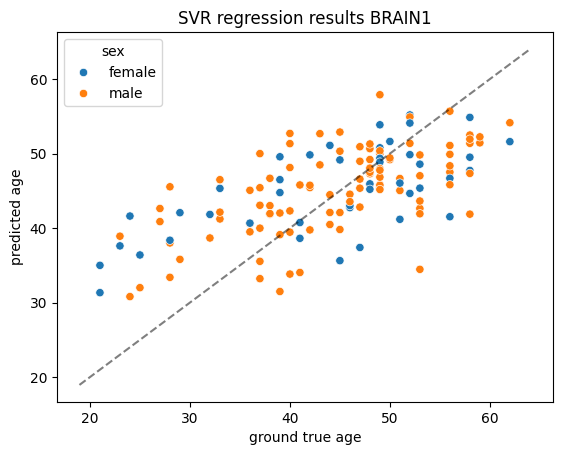

In [26]:
# n_features = 5
# n_features = -1

# sex = 'male'
print(data.shape[0])

# n_features = n_opt_features[organ][sex]
n_features = 8

X = data[data.columns[sorted_corr_ids[:n_features]]].values
# y = data_header['Age'].loc[data_header['sex'] == sex].values
y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

diagnosis = data_header['sex'] #.loc[data_header['sex'] == sex]
# print(X.shape)
print(f"{n_features=}")



cv = StratifiedKFold(n_splits=5)
# cv = LeaveOneOut()

preds = []
vals  = []
gls_preds = []

rmses = []
maes = []
r2s = []

for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
    X_train = X[train]
    y_train = y[train]
    X_test = X[val]
    y_test = y[val]

    # train_scaler = RobustScaler().fit(X_train)
    # test_scaler = RobustScaler().fit(X_test)
    # X_train = train_scaler.transform(X_train)
    # X_test = test_scaler.transform(X_test)

    X_train_ = X_train
    y_train_ = y_train
    
    X_val = X_test
    y_val = y_test
    
    model = svm.SVR(kernel='linear')
    # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
    # model = LinearRegression()
    # model = Ridge()
    # model = XGBRegressor(n_estimators=300, max_depth=4, )
    # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
    #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
    model.fit(X_train_, y_train_)
    
    
    # X_train_ = sm.add_constant(X_train_)
    # X_test = sm.add_constant(X_test, has_constant='add')
    
    # mod = sm.GLM(y_train_, X_train_,
    #                 family=sm.families.NegativeBinomial()).fit()
    
    # gls_pred = mod.predict(X_test)
    # preds.append(gls_pred)
    
    pred = model.predict(X_val)
    preds.extend(pred)
    vals.extend(y_val)

print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
# print("RMSE: ", RMSE(gls_preds, vals))
print("MAE: ", MAE(np.ravel(preds), np.ravel(vals)))
print("R2: ", r2_score(vals, preds))

# model.coef_

colors = {
    'male': 'blue',
    "female": "orange"
}

g = sns.scatterplot(
    x=np.array(vals).ravel(), 
    y=np.array(preds).ravel(), 
    # color=colors[sex],
    hue=diagnosis
    )
g.set_title(f"SVR regression results {organ}")
g.set_ylabel("predicted age")
g.set_xlabel("ground true age")

lims = [
    np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
    np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
]


g.plot(lims, lims, '--', color='k', alpha=0.5)

# g.set_xlim(lims)
# g.set_ylim(lims)

transcripts[organ][sex] = data.columns[sorted_corr_ids[:n_features]].tolist()
model.coef_


In [27]:
data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"]

SRR19147434    41
SRR19147435    28
SRR19147436    27
SRR19147437    33
SRR19147438    40
               ..
SRR19147622    53
SRR19147623    48
SRR19147624    29
SRR19147625    62
SRR19147626    48
Name: Age, Length: 144, dtype: int64

Text(37.722222222222214, 0.5, 'Age')

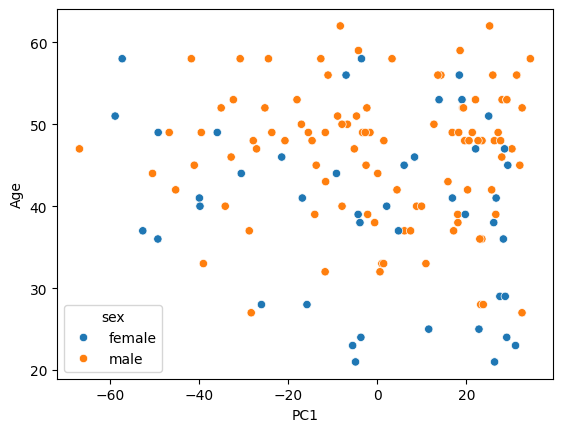

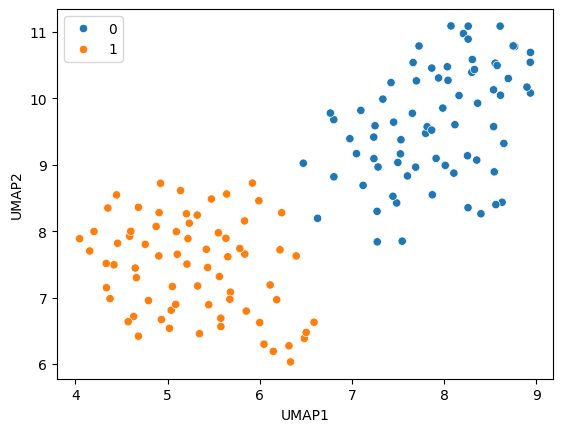

<Figure size 640x480 with 0 Axes>

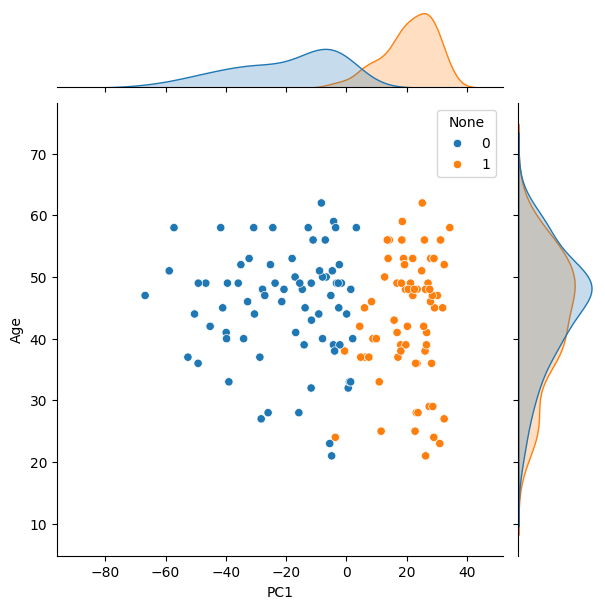

In [32]:
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture


# Putamen | Caudate | Nac

n_features = 20

# X_ = data_both.values
# y_ = data_header_both['Age'].values

X_ = data.loc[data_header['tissue'] != "Nac"].values
y_ = data_header['Age'].loc[data_header['tissue'] != "Nac"].values
    
    
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_)
# sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['tissue'])
sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"])
# X_pca.shape
plt.xlabel("PC1")
plt.ylabel("Age")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)


reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_)

# clusterer = KMeans(n_clusters=2)
# clusterer = DBSCAN()
clusterer = GaussianMixture(n_components=2)

clusterer.fit(X_umap)
# labels = clusterer.labels_
labels = clusterer.predict(X_umap)

plt.figure()
# sns.scatterplot(x=X_pca[:, 0], y=y_, hue=data_header_both['tissue'])
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels)
# X_pca.shape
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)

plt.figure()
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_)
sns.jointplot(x=X_pca[:, 0], y=y_, hue=labels)
# sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels)
# X_pca.shape
plt.xlabel("PC1")
plt.ylabel("Age")
# plt.figure()
# plt.plot(pca.explained_variance_ratio_)

In [42]:

from sklearn.preprocessing import PolynomialFeatures



print(data.shape[0])

# X_ = data_both.loc[data_header_both['tissue'] != "Nac"].values
# y_ = data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"].values

for n_features in range(1, np.min([data.shape[0]+1, len(sorted_corr_ids)+1, 20])):
# for n_features in [2]:

    # X = data_both[data_both.columns[sorted_corr_ids[:n_features]]].values
    # # y = data_header['Age'].loc[data_header['sex'] == sex].values
    # y = data_header_both['Age'].loc[data_header_both['tissue'] != "Nac"].values
    
    X = data[data.columns[sorted_corr_ids[:n_features]]].loc[data_header['tissue'] != "Nac"].values
    y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values
    
    # X = data[data.columns[sorted_corr_ids[:n_features]]].values
    # # y = data_header['Age'].loc[data_header['sex'] == sex].values
    # y = data_header['Age'].loc[data_header['tissue'] != "Nac"].values

    X = X[np.argwhere(labels == 1).ravel()]
    y = y[np.argwhere(labels == 1).ravel()]
    
    print(X.shape)
    print(f"{n_features=}")
    
    cv = StratifiedKFold(n_splits=5)
    # cv = LeaveOneOut()

    preds = []
    vals  = []
    gls_preds = []
    
    rmses = []
    r2s = []

    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]

        # train_scaler = RobustScaler().fit(X_train)
        # test_scaler = RobustScaler().fit(X_test)
        # X_train = train_scaler.transform(X_train)
        # X_test = test_scaler.transform(X_test)

        X_train_ = X_train
        y_train_ = y_train
        
        X_val = X_test
        y_val = y_test
        
        # X_val = data_eval[data_eval.columns[sorted_corr_ids[:n_features]]].values
        # y_val = data_eval_header['Age'].loc[data_eval_header['sex']==sex].values

        # poly = PolynomialFeatures(degree=2)
        # X_train_ = poly.fit_transform(X_train_)
        # X_val = poly.transform(X_val)
        
        model = svm.SVR(kernel='linear')
        # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
        # model = LinearRegression()
        # model = Ridge()
        # model = XGBRegressor(n_estimators=300, max_depth=4, )
        # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
        #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        # # print(f"{X_train_.shape=}")
        # # print(f"{X_val.shape=}")
        # epsilon = 1e-4
        # lam = 0.1
        # iterations = 50
        # random_restarts = 20
        # model = LinearRegressionsMixture(X_train_, np.expand_dims(y_train_, axis=1), K=2)
        # model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)
        # pred = [model.predict(X_val[i]) for i in range(X_val.shape[0])]

        preds.extend(pred)
        vals.extend(y_val)
                
        # X_train_ = sm.add_constant(X_train_)
        # X_test = sm.add_constant(X_test, has_constant='add')
        
        # mod = sm.GLM(y_train_, X_train_,
        #              family=sm.families.NegativeBinomial()).fit()
        
        # gls_pred = mod.predict(X_test)
        # gls_preds.extend(gls_pred)
        

    print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
    print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
    # print("GLM RMSE: ", RMSE(gls_preds, vals))
    # print("GLM R2: ", r2_score(vals, gls_preds))
    
    # print("GLM RMSE: ", np.mean(rmses))
    # print("GLM R2: ", np.mean(r2s))
    
    # print(data.columns[sorted_corr_ids[:n_features]])
    print("-"*20)
    # print(model.coef_)
    # print(model.intercept_)

    # plt.plot(vals, "bo")
    # plt.plot(preds, "ro")
    # plt.show()

model.coef_

144
(71, 1)
n_features=1


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1295.98it/s]


RMSE:  9.127849116878709
R2:  0.1634716174473434
--------------------
(71, 2)
n_features=2


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1225.90it/s]


RMSE:  9.035494658658084
R2:  0.18031376404958155
--------------------
(71, 3)
n_features=3


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1144.42it/s]


RMSE:  8.813326317129754
R2:  0.22012773380194328
--------------------
(71, 4)
n_features=4


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1076.95it/s]


RMSE:  8.641487749021064
R2:  0.25024251052903634
--------------------
(71, 5)
n_features=5


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 459.92it/s]


RMSE:  8.43802165003779
R2:  0.2851333344953809
--------------------
(71, 6)
n_features=6


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1013.85it/s]


RMSE:  8.661401168775885
R2:  0.24678305108582943
--------------------
(71, 7)
n_features=7


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1081.28it/s]


RMSE:  8.552408500130026
R2:  0.26562032524147805
--------------------
(71, 8)
n_features=8


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1131.15it/s]


RMSE:  8.262841422437067
R2:  0.31450765147989357
--------------------
(71, 9)
n_features=9


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1020.71it/s]


RMSE:  8.343866432867525
R2:  0.30099792934054714
--------------------
(71, 10)
n_features=10


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1219.42it/s]


RMSE:  8.423253565870718
R2:  0.2876334400876315
--------------------
(71, 11)
n_features=11


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1135.68it/s]


RMSE:  8.392231724000748
R2:  0.2928709005889395
--------------------
(71, 12)
n_features=12


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1055.38it/s]


RMSE:  8.400229926000153
R2:  0.29152240196076495
--------------------
(71, 13)
n_features=13


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1089.09it/s]


RMSE:  7.8253694331459185
R2:  0.3851722305141686
--------------------
(71, 14)
n_features=14


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1000.50it/s]


RMSE:  7.977579861474638
R2:  0.3610217191895255
--------------------
(71, 15)
n_features=15


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 904.92it/s]


RMSE:  7.983309986821811
R2:  0.36010346060265774
--------------------
(71, 16)
n_features=16


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1021.41it/s]


RMSE:  8.079982364350249
R2:  0.34451221766174345
--------------------
(71, 17)
n_features=17


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1076.35it/s]


RMSE:  7.889792197452802
R2:  0.375007356890109
--------------------
(71, 18)
n_features=18


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1071.67it/s]


RMSE:  7.725788210393023
R2:  0.40072056783463794
--------------------
(71, 19)
n_features=19


0it [00:00, ?it/s]/home/ar3/Documents/PYTHON/RNASeqAnalysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
5it [00:00, 1096.72it/s]

RMSE:  7.751792936069433
R2:  0.3966794720738699
--------------------


array([[-0.10060605,  3.55268675, -1.9272347 ,  0.11950483,  2.48502955,
        -2.18541273,  0.95550403, -1.30300818, -1.17425371, -1.91722536,
         0.22259203, -0.02949038,  3.32648391, -0.08768893, -2.7035493 ,
         1.61489454,  1.60907133, -0.39253091, -1.06741569]])

In [ ]:
print(np.argsort(np.abs(pca.components_[0]))[::-1][:10])
print(pca.components_[0][np.argsort(np.abs(pca.components_[0]))[::-1][:10]])
print(data_both.columns[np.argsort(np.abs(pca.components_[0]))[::-1][:10]])

sns.stripplot(
    x=labels,
    # x=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"],
    # y=data_both.loc[data_header_both['tissue'] != "Nac"].iloc[:, np.argsort(np.abs(pca.components_[0]))[::-1][5]],
    y=data_both.loc[data_header_both['tissue'] != "Nac", 'ENST00000431584.2'],
    hue=data_header_both['sex'].loc[data_header_both['tissue'] != "Nac"]
)


In [ ]:
import anndata as ad
import scanpy as sc

# select by by variance

gtf_rawdata = read_gtf(fdir_raw / 'all_transcripts_strigtie_merged.gtf')
gtf_data = gtf_rawdata.to_pandas()
gtf_data = gtf_data.set_index('transcript_id')
gtf_data['transcript_id'] = gtf_data.index

gtf_data = gtf_data.loc[data.columns].drop_duplicates("transcript_id")
# adata = ad.AnnData(data_both)
# adata.var = gtf_data
# adata.obs = data_header_both

adata = ad.AnnData(data_both.loc[data_header_both['tissue'] != "Nac"])
adata.var = gtf_data
adata.obs = data_header_both.loc[data_header_both['tissue'] != "Nac"]


In [ ]:
adata.obs.columns

In [ ]:
# adata.obs['disease_state']

sc.tl.pca(adata)

# sc.pl.pca(adata, color='disease_state')
sc.pl.pca(adata, color=['tissue', 'tissue', 'sex', 'sex'],
          dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
          ncols=2)
# source_name, tissue => batch effect
sc.pl.pca_variance_ratio(adata, n_pcs=5)


In [ ]:
adata.obs.columns

# adata.obs['Sample Name']

In [ ]:
sc.pl.pca(adata, 
          color=['Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject',
                 'BMI', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype',
                 'DATASTORE provider', 'DATASTORE region', 'disease_state',
                 'gender', 'Instrument', 'library_size', 'LibraryLayout',
                 'LibrarySelection', 'LibrarySource', 'manner_of_death', 'Organism',
                 'patients_ID', 'PH', 'Platform', 'pmi', 'RACE', 'ReleaseDate', 'RIN',
                 'version', 'Sequence_ID', 'source_name',
                 'SRA Study', 'tissue', 'tissuestoragetime', 'sex'],
          ncols=2)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['source_name', 'tissue', 'disease_state', 'sex'], ncols=2)

In [ ]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5)
sc.pl.pca(adata, color=["leiden"])


In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", n_genes=10,
)

sc.get.rank_genes_groups_df(adata, group="0").head(5)
# sc.get.rank_genes_groups_df(adata, group="1").head(5)

In [ ]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="1").head(5)["names"]
sc.pl.pca(
    adata,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

In [38]:
# import copy
# transcripts_dict = copy.deepcopy(transcripts)

# # for organ in ['BRAIN0', "HEART", "BRAIN1"]:
# #     for sex in ['female', 'male']:
# #         transcripts_dict[organ][sex] = [".".join(el.split(".")[:-1]) for el in transcripts_dict[organ][sex]]
# transcripts_dict


In [ ]:
# adata.obs['Age']
sns.scatterplot(y=adata.obs['Age'], x=adata.obsm['X_pca'][:, 0], hue=adata.obs['leiden'])

In [ ]:
adata

In [488]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

In [ ]:

sex = ['male', 'female'][1]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1"]:
    # test_dict[organ] = set(transcripts_dict[organ][sex])
    test_dict[organ] = set(transcripts_dict[organ]['male']).union(set(transcripts_dict[organ]['female']))


plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('dataset')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


In [ ]:
organ = ['BRAIN0', "HEART", "BRAIN1"][1]
test_dict = {}
for sex in ['male', 'female']:
    test_dict[sex] = set(transcripts_dict[organ][sex])

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

g.axes['main'].set_ylabel(organ)

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

reducer = PCA(n_components=4)

X_transformed = reducer.fit_transform(X)

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], ax=axs[0])
sns.scatterplot(x=X_transformed[:, 2], y=X_transformed[:, 3], ax=axs[1])
# sns.scatterplot(x=X[:, 2], y=X[:, 3], ax=axs[1])
